https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html#Large-Movie-Review-Dataset

https://github.com/sahilee26/IMDB-Movie-Reviews-Sentiment-Analysis/blob/master/Bag-of-words-random-forest.ipynb

제출 : https://www.kaggle.com/c/word2vec-nlp-tutorial

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
filepath = '/content/gdrive/My Drive/' + 'csv/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


라이브러리 로드

In [2]:
import pandas as pd
import numpy as np
# import os
import matplotlib.pyplot as plt
import seaborn as sn
# import pickle

%matplotlib inline

#Import module to split the datasets
# from sklearn.model_selection import train_test_split
# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

데이터 위치에 대한 변수를 설정

In [3]:
# Global parameters
#root folder
# root_folder='.'
# data_folder_name='data'
glove_filename='glove.6B.100d.txt'

# train_filename='train.csv'
# Variable for data directory
# DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
# glove_path = os.path.abspath(os.path.join(DATA_PATH, glove_filename))
glove_path = filepath + glove_filename

# Both train and test set are in the root data directory
# train_path = DATA_PATH
# test_path = DATA_PATH

#Relevant columns ??
# TEXT_COLUMN = 'text'
# TARGET_COLUMN = 'target'

# 사전 훈련된 단어 임베딩 로드: GloVe
- 사용 편의성을 위해 단어 삽입이 포함된 GloVe 파일을 word2vec 형식으로 변환
  - Globe2word2vec라는 함수인 gensim 라이브러리를 사용하여 이를 수행

In [4]:
# We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format
# that will be loaded in the next section
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
word2vec_output_file = glove_filename+'.word2vec' # ??
%time glove2word2vec(glove_path, word2vec_output_file)

<timed eval>:1: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).


CPU times: user 1min 4s, sys: 1.99 s, total: 1min 6s
Wall time: 1min 23s


(400000, 100)

- 우리 어휘에는 모양 100의 특징 벡터로 표현되는 400,000개의 단어가 포함되어 있습
- word2vec 형식으로 Glove 임베딩을 로드한 다음 몇 가지 유추를 분석할 수 있습
- 이런 방식으로 사전 훈련된 word2vec 임베딩을 사용하려면 파일 이름을 변경


In [5]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
# word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
print('King: ',model.get_vector('king'))

result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print('Most similar word to King + Woman: ', result)

King:  [-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

벡터 공간을 분석하고 유사점 찾기

In [42]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print('King - Man + Woman = ',result)

King - Man + Woman =  [('queen', 0.7698540687561035)]


In [43]:
result = model.most_similar(positive=['spain'], topn=10)
print('10 most similar words to Spain: ',result)

10 most similar words to Spain:  [('portugal', 0.797070324420929), ('argentina', 0.7758234143257141), ('italy', 0.7746188044548035), ('france', 0.7557463645935059), ('spanish', 0.734722375869751), ('brazil', 0.724494457244873), ('mexico', 0.7206876277923584), ('madrid', 0.7078268527984619), ('morocco', 0.7001035213470459), ('netherlands', 0.6802704334259033)]


# 단어 임베딩 시각화
- 2D 공간에 플로팅하면 단어가 어떻게 관련되어 있는지 보여줄 수 있
- 이를 위해서는 차원을 2 또는 3으로 만들기 위한 추가 차원 축소 기술이 필요
- 가장 널리 사용되는 축소 기술은 그 자체로 임베딩 방법인 TSNE(t-Distributed Stochastic Neighbor Embedding)
  - t-SNE는 t-분포 확률적 이웃 임베딩을 나타냅니다. 고차원 데이터 세트의 시각화에 가장 적합한 차원 축소 기술
  - TSNE는 고차원 데이터를 저차원 다양체에 매핑하여 데이터 내의 로컬 구조를 유지하려고 시도하는 임베딩을 생성하는 매니폴드 학습 기술


<-테스트

In [6]:
np.empty((0,10), dtype='f') # (0, dim)은 행과 열의 크기 / f'는 부동 소수점 형식 / 2차원이지만 행이 0개므로 처음엔 아무 데이터가 없음. 나중에 데이터 추가할 때 사용

array([], shape=(0, 10), dtype=float32)

In [7]:
model['dog']

array([ 0.30817  ,  0.30938  ,  0.52803  , -0.92543  , -0.73671  ,
        0.63475  ,  0.44197  ,  0.10262  , -0.09142  , -0.56607  ,
       -0.5327   ,  0.2013   ,  0.7704   , -0.13983  ,  0.13727  ,
        1.1128   ,  0.89301  , -0.17869  , -0.0019722,  0.57289  ,
        0.59479  ,  0.50428  , -0.28991  , -1.3491   ,  0.42756  ,
        1.2748   , -1.1613   , -0.41084  ,  0.042804 ,  0.54866  ,
        0.18897  ,  0.3759   ,  0.58035  ,  0.66975  ,  0.81156  ,
        0.93864  , -0.51005  , -0.070079 ,  0.82819  , -0.35346  ,
        0.21086  , -0.24412  , -0.16554  , -0.78358  , -0.48482  ,
        0.38968  , -0.86356  , -0.016391 ,  0.31984  , -0.49246  ,
       -0.069363 ,  0.018869 , -0.098286 ,  1.3126   , -0.12116  ,
       -1.2399   , -0.091429 ,  0.35294  ,  0.64645  ,  0.089642 ,
        0.70294  ,  1.1244   ,  0.38639  ,  0.52084  ,  0.98787  ,
        0.79952  , -0.34625  ,  0.14095  ,  0.80167  ,  0.20987  ,
       -0.86007  , -0.15308  ,  0.074523 ,  0.40816  ,  0.0192

In [8]:
test_arr = np.empty((0,100), dtype='f')

test_word_labels = ['man', 'dog']

test_close_words=[]
for word in test_word_labels:
    test_arr = np.append(test_arr, np.array([model[word]]), axis=0)
    test_close_words +=model.similar_by_word(word)

print(test_arr.shape)
print(test_arr)
print(test_close_words)

(2, 100)
[[ 3.7293e-01  3.8503e-01  7.1086e-01 -6.5911e-01 -1.0128e-03  9.2715e-01
   2.7615e-01 -5.6203e-02 -2.4294e-01  2.4632e-01 -1.8449e-01  3.1398e-01
   4.8983e-01  9.2560e-02  3.2958e-01  1.5056e-01  5.7317e-01 -1.8529e-01
  -5.2277e-01  4.6191e-01  9.2038e-01  3.1001e-02 -1.6246e-01 -4.0567e-01
   7.8621e-01  5.7722e-01 -5.3501e-01 -6.8228e-01  1.6987e-01  3.6310e-01
  -7.1773e-02  4.7233e-01  2.7806e-02 -1.4951e-01  1.7543e-01 -3.7573e-01
  -7.8517e-01  5.8171e-01  8.6859e-01  3.1445e-02 -4.5897e-01 -4.0917e-02
   9.5897e-01 -1.6975e-01  1.3045e-01  2.7434e-01 -6.9485e-02  2.2402e-02
   2.4977e-01 -2.1536e-01 -3.2406e-01 -3.9867e-01  6.8613e-01  1.7923e+00
  -3.7848e-01 -2.2477e+00 -7.7025e-01  4.6582e-01  1.2411e+00  5.7756e-01
   4.1151e-01  8.4328e-01 -5.4259e-01 -1.6715e-01  7.3927e-01 -9.3477e-02
   9.0278e-01  5.0889e-01 -5.0031e-01  2.6451e-01  1.5443e-01 -2.9432e-01
   1.0906e-01 -2.6667e-01  3.5438e-01  4.9079e-02  1.8018e-01 -5.8590e-01
  -5.5542e-01 -2.8987e-01  7.

In [9]:
test_close_words[0][0]

'woman'

In [10]:
np.empty(10)

array([1.4115e-320, 7.7771e-320, 5.3359e-321, 9.5572e-320, 2.8547e-320,
       2.8547e-320, 9.5572e-320, 5.3359e-321, 7.7771e-320, 1.4115e-320])

In [11]:
[model.similar_by_word(word) for word in ['dog']]

[[('cat', 0.8798074126243591),
  ('dogs', 0.8344309329986572),
  ('pet', 0.7449564337730408),
  ('puppy', 0.723637580871582),
  ('horse', 0.7109653949737549),
  ('animal', 0.6817063093185425),
  ('pig', 0.655417263507843),
  ('boy', 0.6545308232307434),
  ('cats', 0.6471932530403137),
  ('rabbit', 0.6468630433082581)]]

In [12]:
[model.similar_by_word(word) for word in ['man', 'dog']]

[[('woman', 0.8323495388031006),
  ('boy', 0.7914870977401733),
  ('one', 0.7788748741149902),
  ('person', 0.7526816725730896),
  ('another', 0.7522234916687012),
  ('old', 0.7409117221832275),
  ('life', 0.7371697425842285),
  ('father', 0.7370322346687317),
  ('turned', 0.7347694635391235),
  ('who', 0.7345511317253113)],
 [('cat', 0.8798074126243591),
  ('dogs', 0.8344309329986572),
  ('pet', 0.7449564337730408),
  ('puppy', 0.723637580871582),
  ('horse', 0.7109653949737549),
  ('animal', 0.6817063093185425),
  ('pig', 0.655417263507843),
  ('boy', 0.6545308232307434),
  ('cats', 0.6471932530403137),
  ('rabbit', 0.6468630433082581)]]

테스트->

In [13]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def display_closestwords_tsnescatterplot(model, dim, words):

    arr = np.empty((0,dim), dtype='f')
    word_labels = words

    # get close words
    #close_words = [model.similar_by_word(word) for word in words]

    # add the vector for each of the closest words to the array
    close_words=[]
    for word in words:
        arr = np.append(arr, np.array([model[word]]), axis=0)
        close_words +=model.similar_by_word(word)

    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    # x 좌표와 y 좌표 추출
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    # x 및 y 축의 범위를 설정
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

def tsne_plot(model, words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    #for word in model.wv.vocab:
    for word in words:
        tokens.append(model[word])
        labels.append(word)
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    # print("check point")
    tokens=np.array(tokens)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(14, 10))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

단어 임베딩에서 100개의 단어를 구성하고 여성 및 자동차 개념과 가장 유사한 단어도 표시

In [14]:
# model.key_to_index.keys()
# list(model.key_to_index.keys())

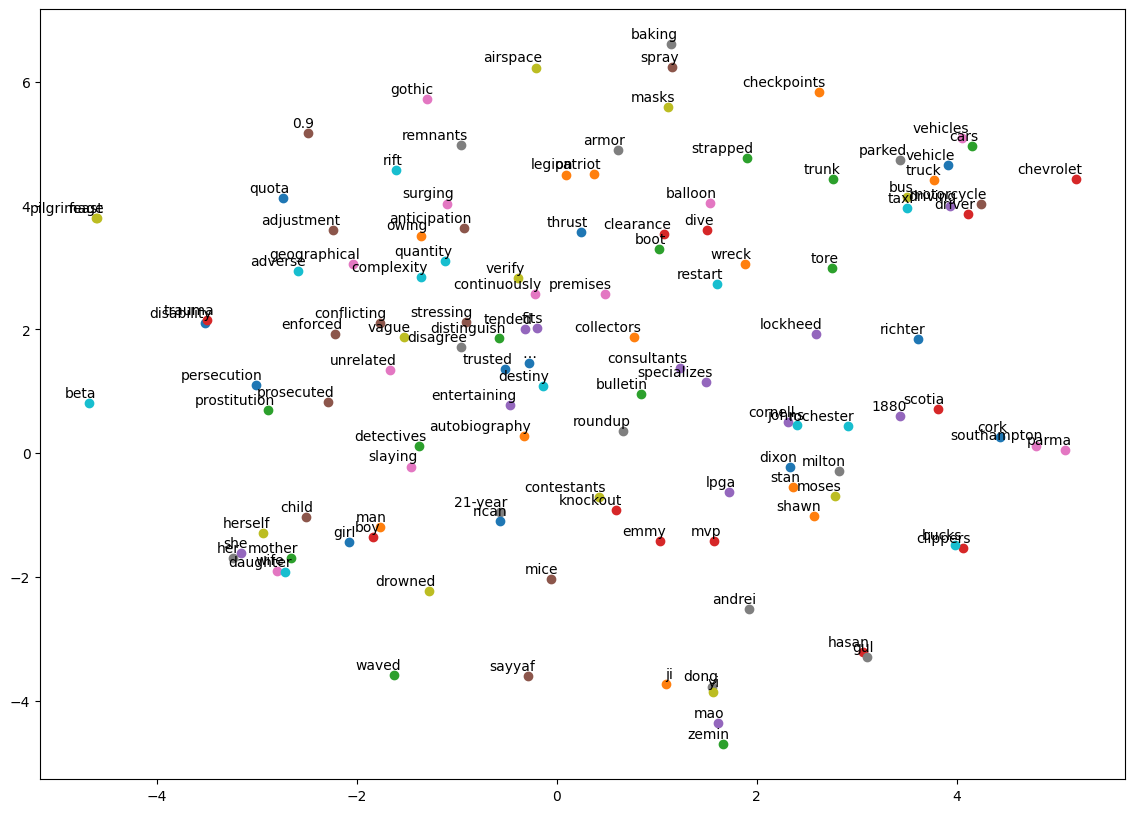

In [15]:
#display_closestwords_tsnescatterplot(model, 100, ['man', 'dog'])

# words=list(model.vocab.keys()) 여기부터
keys_to_indices = model.key_to_index
words = list(keys_to_indices.keys())

word1 = words[10000:10100]
words2= model.similar_by_word('woman')
words3= model.similar_by_word('car')
words= word1 + [w[0] for w in words2] + [w[0] for w in words3]
#print(words)
tsne_plot(model, words)

# 데이터 세트 로드
- 이 데이터세트에서는 토큰이 이미 "숫자화"되어 있지만 일반 텍스트로 표시되기를 원하므로 원래 토큰으로 되돌려야 합
- 그런 다음 데이터 세트를 로드하고 어휘를 로드한 다음 어휘를 사용하여 전체 데이터 세트의 모든 단일 토큰에 대한 원본 토큰을 얻습

In [16]:
"""
header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며
delimiter = \t 는 필드가 탭으로 구분되는 것을 의미한다.
quoting = 3은 쌍따옴표를 무시하도록 한다.
"""
# QUOTE_MINIMAL (0), QUOTE_ALL (1),
# QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

# 레이블인 sentiment 가 있는 학습 데이터
train_path = pd.read_csv('https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/data/labeledTrainData.tsv', delimiter='\t', quoting=3)
# # 레이블이 없는 테스트 데이터
test_path = pd.read_csv('https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/data/testData.tsv', delimiter='\t', quoting=3)
train_path.shape

(25000, 3)

In [17]:
train_path

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."


In [18]:
# from keras.datasets import imdb

# (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=None)
# # print(train_data)
# word_index = imdb.get_word_index()
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# # review = [reverse_word_index.get(i-3, "") for i in train_data[0]]

In [19]:
# print('Vocabulary lenght: ',len(word_index))
# # print('Review example: ',review[:20])
# # print('Label: ',train_labels[0])

In [20]:
!pip show BeautifulSoup4

Name: beautifulsoup4
Version: 4.12.3
Summary: Screen-scraping library
Home-page: 
Author: 
Author-email: Leonard Richardson <leonardr@segfault.org>
License: MIT License
Location: /usr/local/lib/python3.10/dist-packages
Requires: soupsieve
Required-by: gdown, google, nbconvert, yfinance


In [21]:
from bs4 import BeautifulSoup
import re
import nltk
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
from nltk.corpus import stopwords

In [24]:
def review_to_words( raw_review ):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(stemming_words) )

In [25]:
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [26]:
%time X_train = apply_by_multiprocessing(\
    train_path['review'], review_to_words, workers=4)

<ipython-input-24-5a1938eb7345>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
<ipython-input-24-5a1938eb7345>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
<ipython-input-24-5a1938eb7345>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
<ipython-input-24-5a1938eb7345>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSou

CPU times: user 665 ms, sys: 272 ms, total: 936 ms
Wall time: 1min 35s


In [27]:
%time X_test = apply_by_multiprocessing(\
    test_path['review'], review_to_words, workers=4)

<ipython-input-24-5a1938eb7345>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
<ipython-input-24-5a1938eb7345>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
<ipython-input-24-5a1938eb7345>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
<ipython-input-24-5a1938eb7345>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSou

CPU times: user 516 ms, sys: 265 ms, total: 781 ms
Wall time: 1min 4s


In [28]:
# # Convert the train and test dataset to strings of words
# X_train=[]
# for doc in train_data:
#     X_train.append(' '.join([reverse_word_index.get(i - 3, "") for i in doc]))

# X_test=[]
# for doc in test_data:
#     X_test.append(' '.join([reverse_word_index.get(i - 3, "") for i in doc]))

In [29]:
Ytrain = train_path['sentiment']

In [30]:
# X_train = train_path['review']
# Ytrain = train_path['sentiment']

# X_test = test_path['review']

In [31]:
X_test

0        natur film main theme mortal nostalgia loss in...
1        movi disast within disast film full great acti...
2        movi kid saw tonight child love one point kid ...
3        afraid dark left impress sever differ screenpl...
4        accur depict small time mob life film new jers...
                               ...                        
24995    soni pictur classic look soni got right harri ...
24996    alway felt ms merkerson never gotten role fit ...
24997    disappoint movi familiar case read mark fuhrma...
24998    open sequenc fill black white shot reminisc go...
24999    great horror film peopl want vomit retch gore ...
Name: review, Length: 25000, dtype: object

In [32]:
# print(len(X_train),len(X_test))
# print(X_train[0])

# 텍스트 분류 작업에 단어 임베딩 적용
- 이제 우리는 어휘의 모든 단어에 대한 벡터인 단어 표현을 갖게 되었습 ??
- 하지만 전체 문장을 처리해야 하므로 문장 임베딩을 만들어야 합
- 전체 문장을 나타내는 벡터가 필요하며 벡터의 모든 기능은 단어 임베딩을 기반으로 합
- 문장 임베딩의 i번째 값은 문장의 모든 단어에 대한 단어 임베딩의 i번째 값의 평균이 됩 ??
  - "i번째 값"을 계산하기 위해 문장에 있는 모든 단어의 임베딩 벡터에서 i번째 값들을 추출하고, 이를 평균내면 됩
  - ;이 과정을 모든 차원에 대해 반복하면, 문장 임베딩이 생성됩니다.
- 어휘와 장갑 벡터를 포함하는 클래스를 만든 모든 리뷰를 벡터 표현으로 변환

In [33]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    test_m = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
          test_m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    print(f"no words : {test_m}")
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [34]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
# Ytrain = train_labels
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
# Ytest = test_labels

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 25000
no words : 2390963
Numer of samples with no words found: 0 / 25000
no words : 2334694


In [35]:
print(Xtrain.shape,Xtest.shape)

(25000, 100) (25000, 100)


# 문장 임베딩에 대한 분류기 훈련
- 먼저 결과를 플롯하기 위해 몇 가지 도우미 함수를 만듭

In [36]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()

# ROC Curve : 이진 분류 모델의 성능을 시각화
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1) # 거짓 양성률(FPR), 진짜 양성률(TPR), 임계값(thresholds)을 계산
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## 랜덤 포레스트 분류기

In [37]:
from sklearn.ensemble import RandomForestClassifier

# create the model, train it, print scores
# forest = RandomForestClassifier(n_estimators=200)
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest = forest.fit(Xtrain, Ytrain)

print("train score:", forest.score(Xtrain, Ytrain))
# print("test score:", clf.score(Xtest, Ytest))

train score: 1.0


In [38]:
# 테스트 데이터를 넣고 예측한다.
result = forest.predict(Xtest)
result[:10]

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 1])

# 캐글 제출을 위해 예측결과 저장

In [39]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'id':test_path['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",1
3,"""7186_2""",0
4,"""12128_7""",1


In [40]:
output.to_csv('GloVe.csv', index=False, quoting=3)

In [41]:
output_sentiment = output['sentiment'].value_counts()
print(np.abs(output_sentiment[0] - output_sentiment[1]))
output_sentiment

342


1    12671
0    12329
Name: sentiment, dtype: int64